In [1]:
import pandas as pd
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer

In [40]:
df = pd.read_csv('./data/reviews.csv')
df.shape

(512941, 6)

In [3]:
# Group the data by listing_id and concatenate the comments
df_grouped = df.groupby('listing_id')['comments'].apply(lambda x: ' '.join(x.dropna().astype(str))).reset_index()

In [4]:
df_grouped.head()

,listing_id,comments
0,5456,Sylvia is a hostess who is gracious and helpfu...
1,5769,Elizabeth was really nice and friendly. She he...
2,6413,"Had a wonderful time at this awesome, spacious..."
3,6448,Amy and family were wonderful hosts! The house...
4,8502,"The place was nice, it was like a disco in the..."


## Data Cleaning & Pre-processing:
---

In [5]:
tokenizer = RegexpTokenizer(r'\w+')
df['clean_comments'] = df['comments'].apply(lambda x: tokenizer.tokenize(x.lower()) if pd.notnull(x) else [])

In [6]:
import nltk
#nltk.download('wordnet')
#nltk.download('vader_lexicon')

In [7]:
# Adding custom mapping after EDA process (below) showed that instances of 'wa' were intended to be the word 'was' and the WordNetLemmatizer did not pick that up initially
custom_mapping = {'wa':'was'}

In [8]:
lemmatizer = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

df['clean_comments'] = df['clean_comments'].apply(lambda x: [custom_mapping.get(word, lemmatizer.lemmatize(word)) for word in x if word not in stop_words])

## Sentiment Analysis:
---

In [9]:
sid = SentimentIntensityAnalyzer()
df['sentiment_score'] = df['clean_comments'].apply(lambda x: sid.polarity_scores(' '.join(x))['compound'])

In [10]:
# Calculate the average sentiment score for each unique listing_id
average_scores = df.groupby('listing_id')['sentiment_score'].mean()

# Create a new DataFrame with the unique listing_id and their corresponding average scores
df_average_scores = pd.DataFrame({'listing_id': average_scores.index, 'average_score': average_scores.values})

In [11]:
sorted_df = df.sort_values(by='sentiment_score', ascending=False)

pd.set_option('display.max_colwidth', None)

## EDA:
---

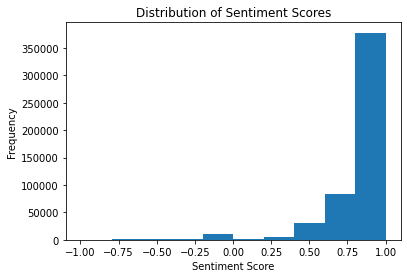

In [12]:
import matplotlib.pyplot as plt

plt.hist(df['sentiment_score'], bins=10)
plt.xlabel('Sentiment Score')
plt.ylabel('Frequency')
plt.title('Distribution of Sentiment Scores')
plt.show()

In [13]:
from collections import Counter

# Words to ignore
ignore_words = ['place', 'stay', 'location', 'austin', 'br', 'host', 'would', 'house',
                'everything', 'space', 'home', 'u', 'was']

# Concatenate all the clean comments into a single list, excluding the ignore words
all_words = [word for comment in df['clean_comments'] for word in comment if word not in ignore_words]

# Compute the frequency distribution of words
word_freq = Counter(all_words)

# Get the top 10 most frequent words (excluding the ignore words)
top_words = [word for word, freq in word_freq.most_common(10) if word not in ignore_words]

# Display the top words and their frequencies
for word, freq in word_freq.items():
    if word in top_words:
        print(word, freq)

easy 69548
great 340286
clean 142025
comfortable 87543
nice 86784
recommend 86545
perfect 93399
definitely 81298
close 66951
super 63231


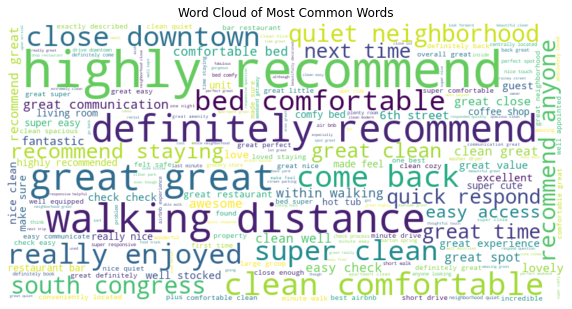

<Figure size 432x288 with 0 Axes>

In [35]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# Create a word cloud from the clean comments
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(' '.join(all_words))

# Display the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Most Common Words')
plt.show()

#plt.savefig('./graphics/word_cloud.png', dpi=300, bbox_inches='tight')

In [15]:
#Investigating why the word cloud above showed 'wa' so much. Corrected in the earlier code and re-ran sentiment analysis.

#wa_df = df[df['comments'].str.contains(r'\bwa\b', case=False, na=False)]
#print(wa_df)

## Results:
---

In [18]:
df_average_scores.head()

,listing_id,average_score
0,5456,0.876553
1,5769,0.877269
2,6413,0.887711
3,6448,0.893526
4,8502,0.813208


In [19]:
df.head(1)

,listing_id,id,date,reviewer_id,reviewer_name,comments,clean_comments,sentiment_score
0,5456,865,2009-03-08,5267,Ellen,"Sylvia is a hostess who is gracious and helpful beyond words! First of all, she wanted to know about our plans and answered all of the questions we had about the city via email before we arrived. She picked us up from the airport and had a handful of maps and magazines about Austin. Her guest house is spotless, adorably decorated, and complete from soap to movies. The neighborhood is charming, and walking distance to cool spots. (We lucked out because her schedule allowed her to show us around the city.) 5 Texas stars!","[sylvia, hostess, gracious, helpful, beyond, word, first, wanted, know, plan, answered, question, city, via, email, arrived, picked, u, airport, handful, map, magazine, austin, guest, house, spotless, adorably, decorated, complete, soap, movie, neighborhood, charming, walking, distance, cool, spot, lucked, schedule, allowed, show, u, around, city, 5, texas, star]",0.9552


In [20]:
import numpy as np

# Replace NaN values in 'clean_comments' column with an empty string
df['clean_comments'] = df['clean_comments'].fillna('')

# Example of User-defined criteria and corresponding weights
criteria_weights = {'downtown': 0.3, 'comfortable': 0.4, 'quiet': 0.3}

# Calculate the weighted average sentiment score and the count of clean_comments for each listing
df['weighted_sentiment_score'] = df.apply(lambda row: sum(criteria_weights.get(term, 0) for term in row['clean_comments']) * row['sentiment_score'], axis=1)
df['clean_comments_count'] = df['clean_comments'].apply(len)

# Filter out listings with less than 10 clean_comments
df_filtered = df[df['clean_comments_count'] >= 10]

# Normalize the weighted scores between 0 and 1
max_weighted_score = df_filtered['weighted_sentiment_score'].max()
min_weighted_score = df_filtered['weighted_sentiment_score'].min()
df_filtered.loc[:, 'normalized_score'] = (df_filtered['weighted_sentiment_score'] - min_weighted_score) / (max_weighted_score - min_weighted_score)

# Calculate the average normalized score and the count of clean_comments for each listing
average_normalized_scores = df_filtered.groupby('listing_id').agg({'normalized_score': 'mean', 'clean_comments_count': 'count'}).reset_index()

# Sort the average_normalized_scores DataFrame by the 'normalized_score' column in descending order
average_normalized_scores = average_normalized_scores.sort_values(by='normalized_score', ascending=False)

# Assign NaN to 'clean_comments_count' for listings with less than 10 clean_comments
average_normalized_scores.loc[average_normalized_scores['clean_comments_count'] < 10, 'clean_comments_count'] = np.nan

# Display the listing_id, normalized_score, and clean_comments_count
print(average_normalized_scores)

               listing_id  normalized_score  clean_comments_count
7288             54355703          0.637200                   NaN
10452  800622169890243077          0.610364                   NaN
10711  829933711098473455          0.609618                   NaN
871               5447513          0.609265                   NaN
8785   673422360986289651          0.608087                   NaN
...                   ...               ...                   ...
6180             50867198          0.200576                   NaN
10449  800057408839589926          0.196960                   NaN
4326             38580142          0.192590                   NaN
8917   682808389374920503          0.169519                   NaN
9677   730992806011609228          0.116235                   NaN

[10796 rows x 3 columns]


<ipython-input-20-b50ec5844744>:19: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_filtered.loc[:, 'normalized_score'] = (df_filtered['weighted_sentiment_score'] - min_weighted_score) / (max_weighted_score - min_weighted_score)


In [21]:
# Drop rows with NaN values under 'clean_comments_count'
average_normalized_scores_filtered = average_normalized_scores.dropna(subset=['clean_comments_count'])

# listing_6935687 = df_average_scores.loc[df_average_scores['listing_id'] == 42333408]
print(listing_6935687)

In [22]:
# Calculate the ranking score based on 'normalized_score'
average_normalized_scores_filtered.loc[:, 'ranking_score'] = average_normalized_scores_filtered['normalized_score'].rank(pct=True)

# Sort the DataFrame by the ranking score in descending order
average_normalized_scores_filtered = average_normalized_scores_filtered.sort_values(by='ranking_score', ascending=False)

# Print the filtered DataFrame
print(average_normalized_scores_filtered)

               listing_id  normalized_score  clean_comments_count  \
999               6935687          0.353144                  13.0   
8150   617383301027592775          0.345763                  12.0   
5047             44684447          0.344526                  10.0   
1995             17319828          0.343722                  11.0   
3483             29538555          0.340996                  16.0   
...                   ...               ...                   ...   
2145             18359829          0.219943                  10.0   
10265  782612057885000202          0.219943                  10.0   
3618             31433462          0.219943                  10.0   
4738             42333408          0.219943                  10.0   
7706   574879619614432279          0.219943                  10.0   

       ranking_score  
999         1.000000  
8150        0.999826  
5047        0.999653  
1995        0.999479  
3483        0.999306  
...              ...  
2145      

<ipython-input-22-5cea93d24d8c>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  average_normalized_scores_filtered.loc[:, 'ranking_score'] = average_normalized_scores_filtered['normalized_score'].rank(pct=True)


## Model Evaluation:
---

In [33]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB

# Convert sentiment scores to categorical labels
threshold = 0.5
train_labels_categorical = ['positive' if score >= threshold else 'negative' for score in train_labels]

# Ensure the number of samples is consistent
df_filtered = df[df['clean_comments'].apply(len) >= 10]
train_data = [' '.join(comment) for comment in df_filtered['clean_comments']]
train_labels_categorical = train_labels_categorical[:len(train_data)]

# Split the data into training and testing sets
train_data, test_data, train_labels_categorical, test_labels = train_test_split(train_data, train_labels_categorical, test_size=0.2, random_state=42)

# Vectorize the text data using TF-IDF
vectorizer = TfidfVectorizer()
train_vectors = vectorizer.fit_transform(train_data)
test_vectors = vectorizer.transform(test_data)

# Train the sentiment analysis model (Multinomial Naive Bayes)
sentiment_analysis_model = MultinomialNB()
sentiment_analysis_model.fit(train_vectors, train_labels_categorical)

# Generate predictions for the test data
predicted_labels_categorical = sentiment_analysis_model.predict(test_vectors)

# Convert predicted labels back to sentiment scores
predicted_scores = [1.0 if label == 'positive' else 0.0 for label in predicted_labels_categorical]

# Evaluate the performance of the model
accuracy = accuracy_score(test_labels, predicted_labels_categorical)
precision = precision_score(test_labels, predicted_labels_categorical, pos_label='positive')
recall = recall_score(test_labels, predicted_labels_categorical, pos_label='positive')
f1 = f1_score(test_labels, predicted_labels_categorical, pos_label='positive')

# Print the evaluation metrics
print('Accuracy:', accuracy)
print('Precision:', precision)
print('Recall:', recall)
print('F1 Score:', f1)

Accuracy: 0.9285753765372392
Precision: 0.9310449953577318
Recall: 0.9971356485604037
F1 Score: 0.9629576546297557
